# FaIR Harmonized
### Erica Simon, 02/05/24
## Purpose: input harmonized historical and projected emissions trajectories into FaIR
Emissions span 1750 to 2100


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
import xarray as xr

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties

## Global Variables

In [2]:
species_configs = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/OMS-NetZero/FAIR/master/examples/data/species_configs_properties_calibration1.2.0.csv',
    known_hash = '4f9d25b21d632cf35953842a627db4b1612b465f68b2a824afff017a7390053b',
)

solar_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-add-hfc/main/data/solar_erf_timebounds.csv',
    known_hash = 'md5:98f6f4c5309d848fea89803683441acf',
)

volcanic_obj = pooch.retrieve(
    url = 'https://raw.githubusercontent.com/chrisroadmap/fair-calibrate/main/data/forcing/volcanic_ERF_1750-2101_timebounds.csv',
    known_hash = 'md5:c0801f80f70195eb9567dbd70359219d',
)

df_solar = pd.read_csv(solar_obj, index_col="year")
df_volcanic = pd.read_csv(volcanic_obj, index_col="timebounds")

# trim `solar_df` to only include 1750-2101.
s_yr_list = list(range(2102, 2301))
df_solar = df_solar.drop(s_yr_list)

In [3]:
GCAM_df = pd.read_csv('~/outputs/GCAM_harm.csv')
MSG_df = pd.read_csv('~/outputs/MSG_harm.csv')
REM_df = pd.read_csv('~/outputs/REM_harm.csv')

# remove 'Emissions|' from variable name
for df in [GCAM_df, MSG_df, REM_df]:
    for i in range(len(df.Variable.values)): 
        df.Variable.values[i] = df.Variable.values[i][10:]

In [4]:
# retrieve climate configs
fair_params_1_2_0_obj = pooch.retrieve(
    url = 'https://zenodo.org/record/10566813/files/calibrated_constrained_parameters.csv',
    known_hash = '76e2b9156ed26aa2730aa7023f1e40025a3637fe479df18e822120eff001848c'
)
df_configs = pd.read_csv(fair_params_1_2_0_obj, index_col=0)

# scaling factors for solar forcing
trend_shape = np.ones(352)
trend_shape[:352] = np.linspace(0, 1, 352)

# Without parameter ensemble
1 config for each scenario

## Create functional format

In [5]:
# input: a dataframe in IAM format with annual emission timeseries for all relevant FaIR species
# returns: a FaIR object that has already been run (check f.temperature for outcomes)

def run_fair(df_emis):
    f = FAIR()
    
    start = int(df_emis.columns[5])   # assumes IAM format consistent with harmonizer
    end = int(df_emis.columns[-1])+1
    f.define_time(start, end, 1)
    
    # use same scenario sames as those in emissions df
    f.define_scenarios(df_emis.Scenario.unique().tolist())
    
    f.define_configs(['c1'])   
    
    ##### define species and properties #####
    species, properties = read_properties(filename=species_configs)

    # removed in examples from fair-calibrate repo, specifically because future projections aren't available
    species.remove("Halon-1202")
    species.remove("NOx aviation")

    f.define_species(species, properties)
    
    # create empty emission and temp arrays
    f.allocate()   
    
    ##### fill emissions #####
    for scen in df_emis.Scenario.unique():
        for var in df_emis.Variable.unique():
            if var in f.species:
                emis = df_emis.loc[df_emis['Variable'] == var].loc[df_emis['Scenario'] == scen].values[0][5:].reshape(351,1)
                fill(f.emissions, emis, scenario=scen, specie=var)
                
    ##### fill forcings #####
    for scen in f.scenarios:
        fill(f.forcing, df_volcanic, scenario=scen, specie='Volcanic')
        fill(f.forcing, df_solar, scenario=scen, specie='Solar')
        
    ##### set configs #####
    fill(f.climate_configs["ocean_heat_transfer"], [1.1, 1.6, 0.9], config='c1')
    fill(f.climate_configs["ocean_heat_capacity"], [8, 14, 100], config='c1')
    fill(f.climate_configs["deep_ocean_efficacy"], 1.1, config='c1')
    f.fill_species_configs()   # default values
    
    ##### initial conditions #####
    initialise(f.concentration, f.species_configs["baseline_concentration"])
    initialise(f.forcing, 0)
    initialise(f.temperature, 0)   # f.temperature refers to temperature anomaly above PI (288 K)
    initialise(f.cumulative_emissions, 0)
    initialise(f.airborne_emissions, 0)
    
    ##### RUN #####
    f.run()
    
    return f

## Run with each model

In [6]:
f_GCAM = run_fair(GCAM_df)
f_MSG = run_fair(MSG_df)
f_REM = run_fair(REM_df)

Running 7 projections in parallel:   0%|          | 0/351 [00:00<?, ?timesteps/s]

Running 7 projections in parallel:   0%|          | 0/351 [00:00<?, ?timesteps/s]

Running 7 projections in parallel:   0%|          | 0/351 [00:00<?, ?timesteps/s]

## Temperature Anomaly
relative to 1850-1900 average temperature

In [63]:
weights_51yr = np.ones(52)
weights_51yr[0] = 0.5
weights_51yr[-1] = 0.5

In [64]:
def calc_anomaly(f):
    return f.temperature.loc[dict(scenario=scen, layer=0)]- np.average(
                        f.temperature.loc[
                            dict(scenario=scen, timebounds=np.arange(1850, 1902), layer=0)
                        ],
                        weights=weights_51yr,
                        axis=0
                        )

## Visualize Outputs

In [65]:
iam_names = {f_GCAM:'GCAM 6.0 NGFS',
             f_MSG:'MESSAGEix-GLOBIOM',
             f_REM:'REMIND-MAgPIE'}

### temp- NOT relative to 1850-1900 avg

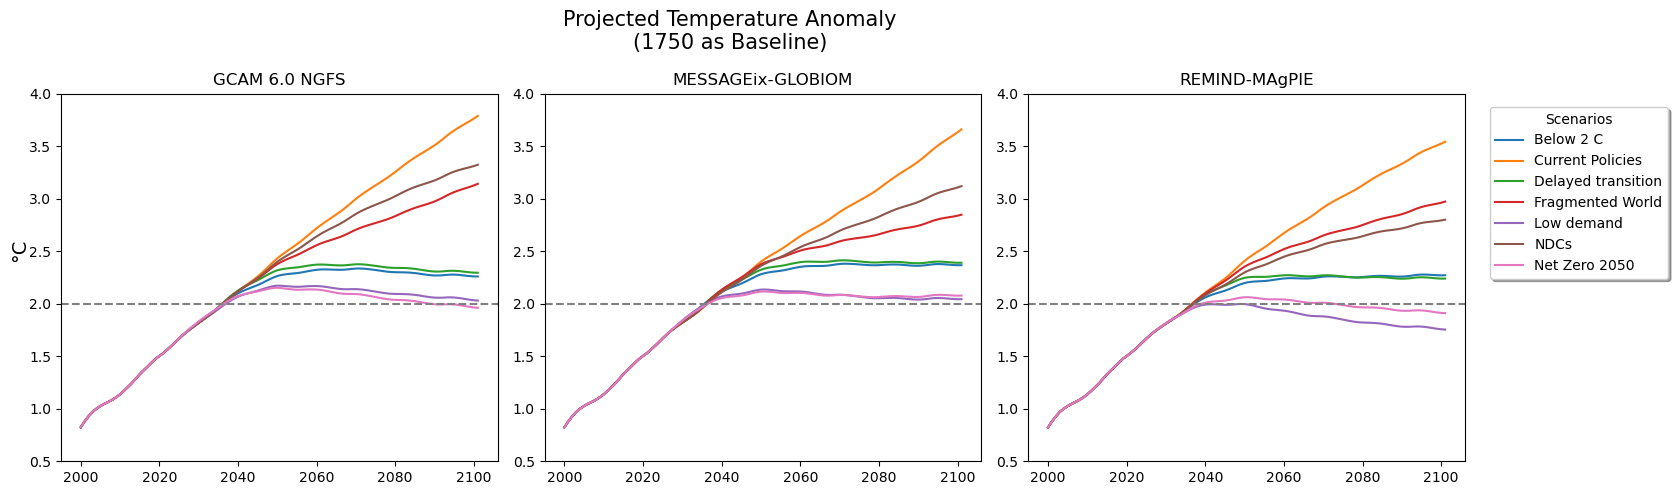

In [93]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, f in enumerate(iam_names):
    labels = []
    ax = axs[i]
    
    for scen in f.scenarios:
        line, = ax.plot(f.timebounds[250:], f.temperature.loc[dict(scenario=scen, layer=0)][250:], label=scen)
        labels.append(line,)
    ax.set_title(iam_names[f])
    ax.axhline(2, color='grey', linestyle='--')
    ax.set_ylim(0.5, 4)

fig.legend(labels, [line.get_label() for line in labels], bbox_to_anchor=(1.13, .8), shadow=True, title='Scenarios')
fig.suptitle('Projected Temperature Anomaly\n(1750 as Baseline)', fontsize=15)
# fig.supxlabel('Year', fontsize=14)
fig.supylabel('°C', fontsize=14)
fig.tight_layout()
fig.show()

### temp relative to 1850-1900 avg

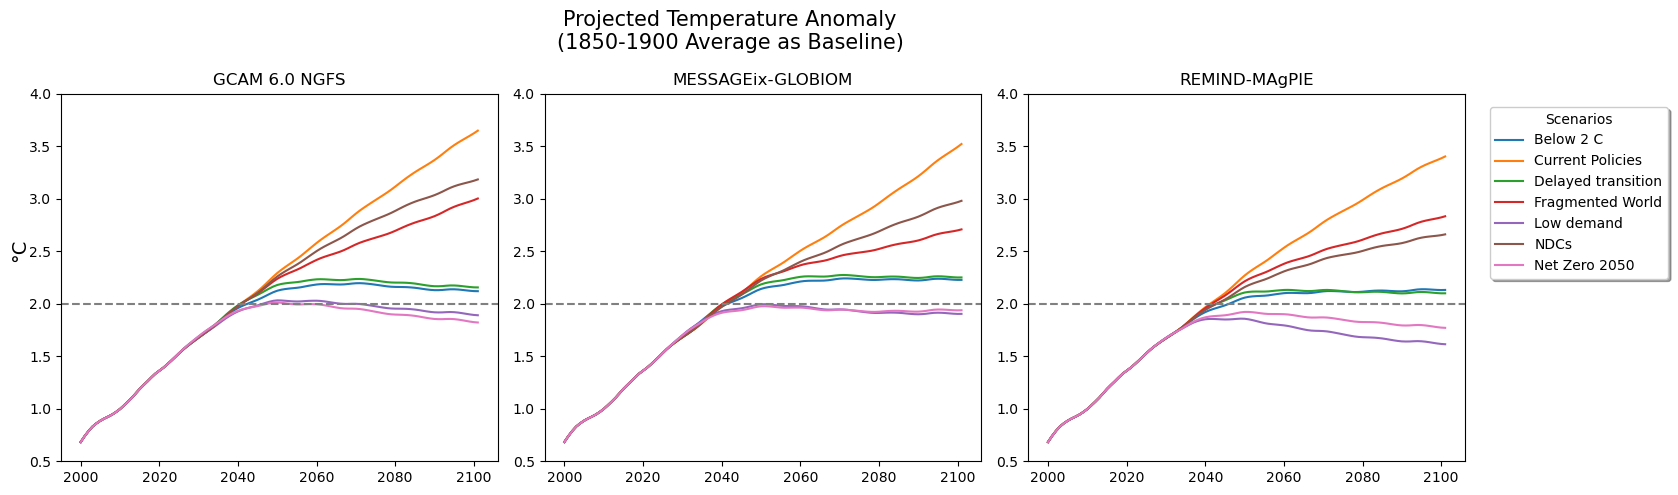

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, f in enumerate(iam_names):
    labels = []
    ax = axs[i]
    
    for scen in f.scenarios:
        line, = ax.plot(f.timebounds[250:], calc_anomaly(f).values[250:], label=scen)
        labels.append(line,)
    ax.set_title(iam_names[f])
    ax.axhline(2, color='grey', linestyle='--')
    ax.set_ylim(0.5, 4)

fig.legend(labels, [line.get_label() for line in labels], bbox_to_anchor=(1.13, .8), shadow=True, title='Scenarios')
fig.suptitle('Projected Temperature Anomaly\n(1850-1900 Average as Baseline)', fontsize=15)
# fig.supxlabel('Year', fontsize=14)
fig.supylabel('°C', fontsize=14)
fig.tight_layout()
fig.show()

### Forcing

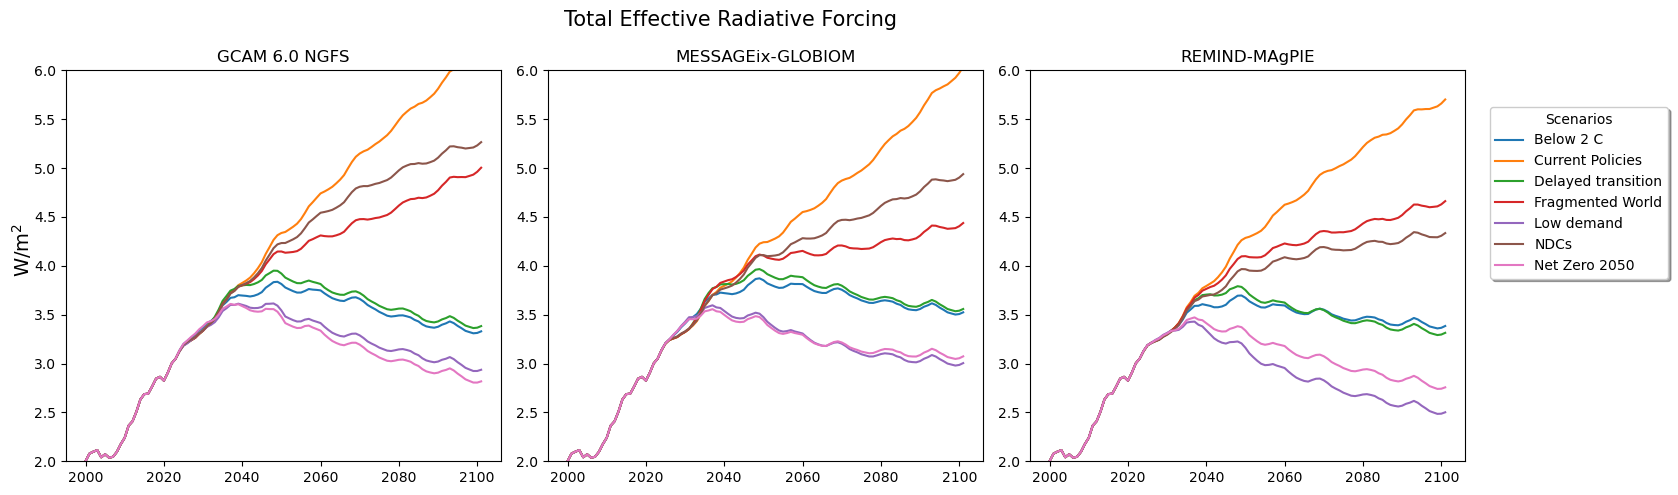

In [71]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, f in enumerate(iam_names):
    labels = []
    ax = axs[i]
    
    for scen in f.scenarios:
        line, = ax.plot(f.timebounds[250:], f.forcing_sum.loc[dict(scenario=scen)].values[250:], label=scen)
        labels.append(line,)
    ax.set_title(iam_names[f])
    ax.set_ylim(2,6)

fig.legend(labels, [line.get_label() for line in labels], bbox_to_anchor=(1.13, .8), shadow=True, title='Scenarios')
fig.suptitle('Total Effective Radiative Forcing', fontsize=15)
# fig.supxlabel('Year', fontsize=14)
fig.supylabel('W/m$^2$', fontsize=14)
fig.tight_layout()
fig.show()

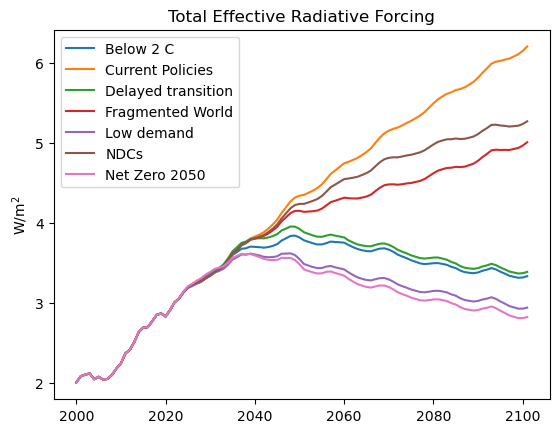

In [70]:
for scen in f_GCAM.scenarios:
     plt.plot(f_GCAM.timebounds[250:], f_GCAM.forcing_sum.loc[dict(scenario=scen)].values[250:], label=scen)
        
plt.title('Total Effective Radiative Forcing')
plt.ylabel('W/m$^2$')
plt.legend()
plt.show()

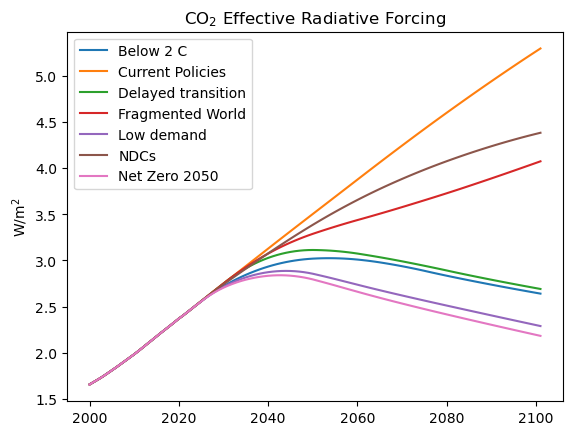

In [72]:
for scen in f_GCAM.scenarios:
     plt.plot(f_GCAM.timebounds[250:], f_GCAM.forcing.loc[dict(scenario=scen, specie='CO2')].values[250:], label=scen)
        
plt.title('CO$_2$ Effective Radiative Forcing')
plt.ylabel('W/m$^2$')
plt.legend()
plt.show()

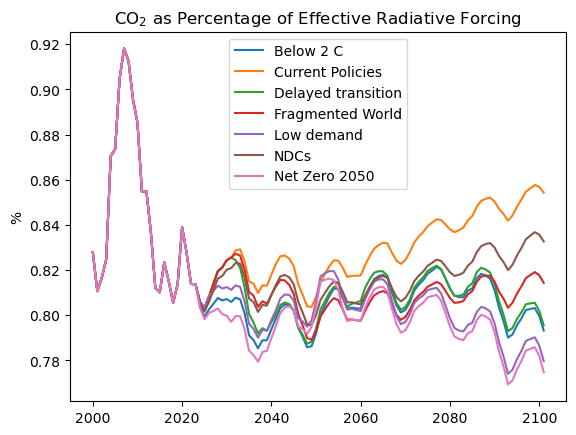

In [46]:
for scen in f_GCAM.scenarios:
     plt.plot(f_GCAM.timebounds[250:], 
              f_GCAM.forcing.loc[dict(scenario=scen, specie='CO2')].values[250:]/f_GCAM.forcing_sum.loc[dict(scenario=scen)].values[250:], 
              label=scen)
        
plt.title('CO$_2$ as Percentage of Effective Radiative Forcing')
plt.ylabel('%')
plt.legend()
plt.show()

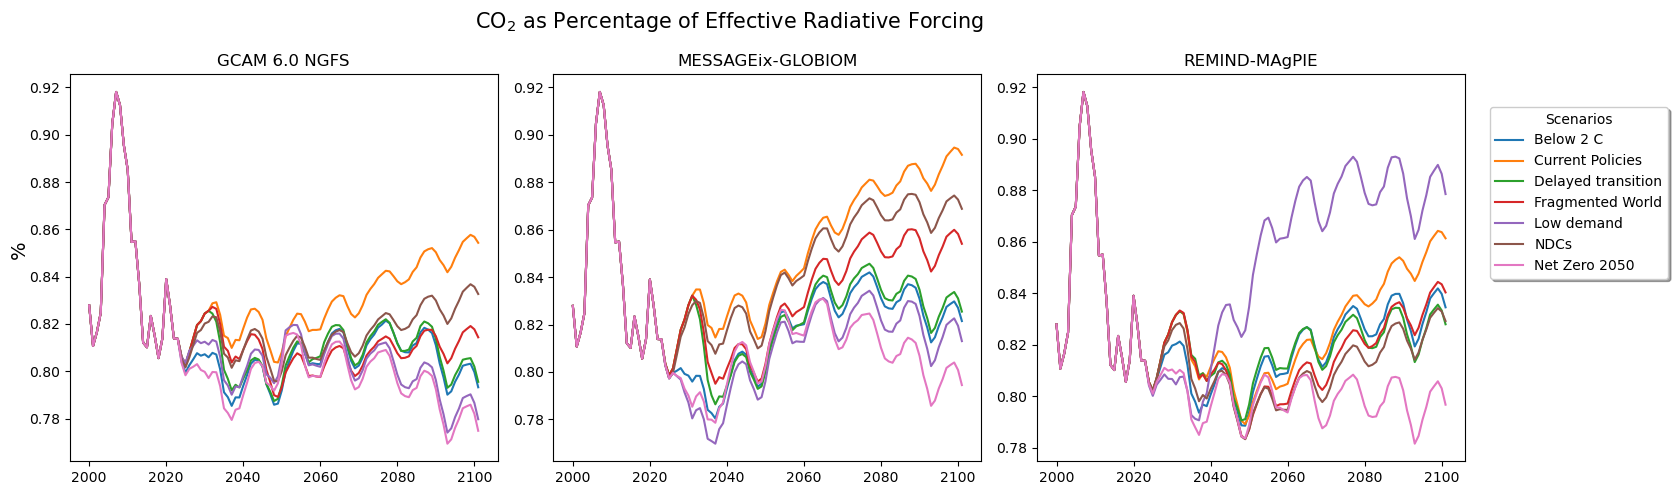

In [76]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, f in enumerate(iam_names):
    labels = []
    ax = axs[i]
    
    for scen in f.scenarios:
        line, = ax.plot(f.timebounds[250:], 
                        f.forcing.loc[dict(scenario=scen, specie='CO2')].values[250:]/f.forcing_sum.loc[dict(scenario=scen)].values[250:],
                        label=scen)
        labels.append(line,)
    ax.set_title(iam_names[f])
    # ax.set_ylim(2,6)

fig.legend(labels, [line.get_label() for line in labels], bbox_to_anchor=(1.13, .8), shadow=True, title='Scenarios')
fig.suptitle('CO$_2$ as Percentage of Effective Radiative Forcing', fontsize=15)
# fig.supxlabel('Year', fontsize=14)
fig.supylabel('%', fontsize=14)
fig.tight_layout()
fig.show()

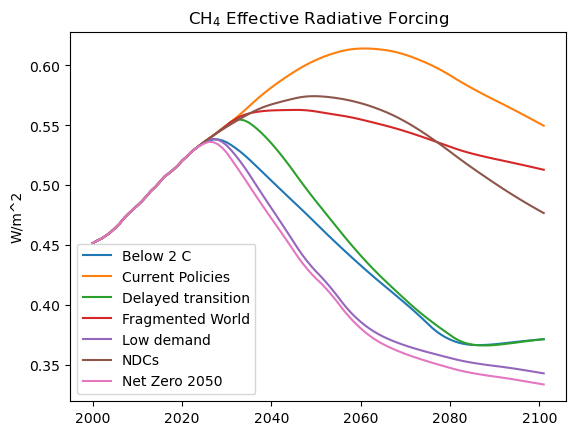

In [50]:
for scen in f_GCAM.scenarios:
     plt.plot(f_GCAM.timebounds[250:], f_GCAM.forcing.loc[dict(scenario=scen, specie='CH4')].values[250:], label=scen)
        
plt.title('CH$_4$ Effective Radiative Forcing')
plt.ylabel('W/m$^2$')
plt.legend()
plt.show()   

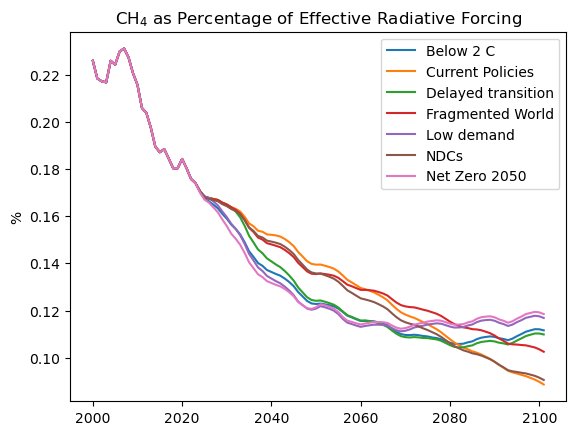

In [48]:
for scen in f_GCAM.scenarios:
     plt.plot(f_GCAM.timebounds[250:], 
              f_GCAM.forcing.loc[dict(scenario=scen, specie='CH4')].values[250:]/f_GCAM.forcing_sum.loc[dict(scenario=scen)].values[250:], 
              label=scen)
        
plt.title('CH$_4$ as Percentage of Effective Radiative Forcing')
plt.ylabel('%')
plt.legend()
plt.show()

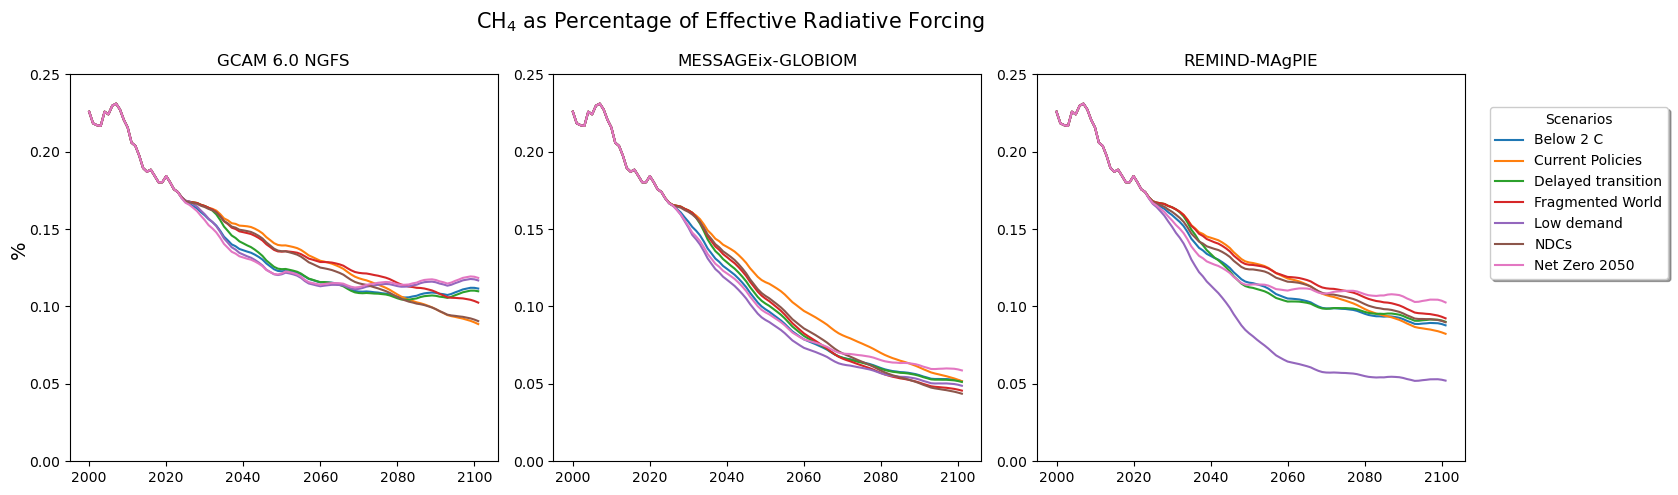

In [78]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, f in enumerate(iam_names):
    labels = []
    ax = axs[i]
    
    for scen in f.scenarios:
        line, = ax.plot(f.timebounds[250:], 
                        f.forcing.loc[dict(scenario=scen, specie='CH4')].values[250:]/f.forcing_sum.loc[dict(scenario=scen)].values[250:],
                        label=scen)
        labels.append(line,)
    ax.set_title(iam_names[f])
    ax.set_ylim(0,0.25)

fig.legend(labels, [line.get_label() for line in labels], bbox_to_anchor=(1.13, .8), shadow=True, title='Scenarios')
fig.suptitle('CH$_4$ as Percentage of Effective Radiative Forcing', fontsize=15)
# fig.supxlabel('Year', fontsize=14)
fig.supylabel('%', fontsize=14)
fig.tight_layout()
fig.show()

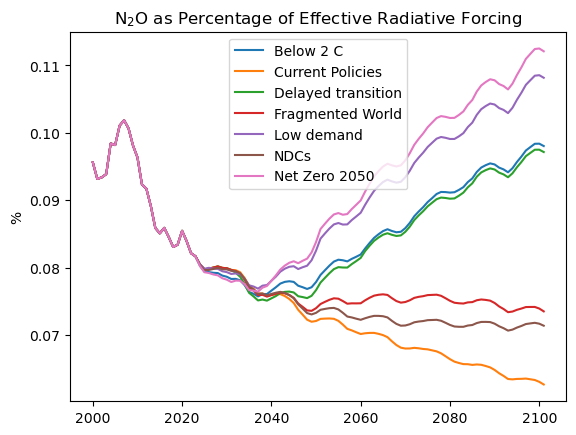

In [49]:
for scen in f_GCAM.scenarios:
     plt.plot(f_GCAM.timebounds[250:], 
              f_GCAM.forcing.loc[dict(scenario=scen, specie='N2O')].values[250:]/f_GCAM.forcing_sum.loc[dict(scenario=scen)].values[250:], 
              label=scen)
        
plt.title('N$_2$O as Percentage of Effective Radiative Forcing')
plt.ylabel('%')
plt.legend()
plt.show()

### concentration

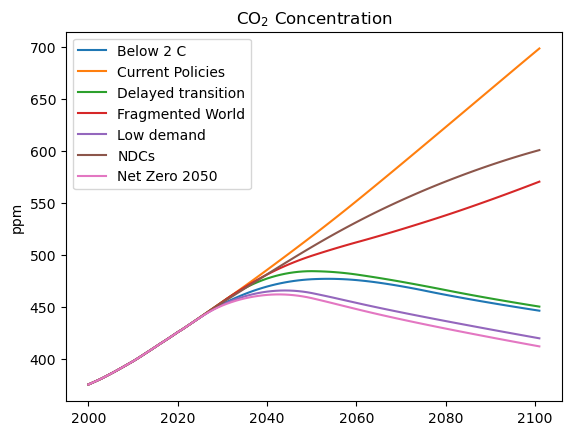

In [53]:
for scen in f_GCAM.scenarios:
     plt.plot(f_GCAM.timebounds[250:], f_GCAM.concentration.loc[dict(scenario=scen, specie='CO2')].values[250:], label=scen)
        
plt.title('CO$_2$ Concentration')
plt.ylabel('ppm')
plt.legend()
plt.show()

### Emissions

In [80]:
f_GCAM.emissions

<xarray.DataArray (timepoints: 351, scenario: 7, config: 1, specie: 62)>
array([[[[ 9.30608418e-03,  1.09921738e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan]],

        [[ 9.30608418e-03,  1.09921738e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan]],

        [[ 9.30608418e-03,  1.09921738e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan]],

        ...,

        [[ 9.30608418e-03,  1.09921738e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan]],

        [[ 9.30608418e-03,  1.09921738e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan]],

        [[ 9.30608418e-03,  1.09921738e-02,  2.02982580e-02, ...,
                      nan,             nan,             nan]]],

...

       [[[-3.42418714e+00, -5.54436433e-01, -3.97862358e+00, ...,
                      nan,             nan,             nan]],

        [[ 4.03131751e+01,  9.20958513e-01,  4.12341336e+01, ...,
                      nan,             nan,             nan]],

        [[-3.40707136e+00, -7.51363289e-01, -4.15843465e+00, ...,
                      nan,             nan,             nan]],

        ...,

        [[-5.54810305e+00, -7.12297562e-01, -6.26040061e+00, ...,
                      nan,             nan,             nan]],

        [[ 1.85957332e+01,  2.56018792e-01,  1.88517520e+01, ...,
                      nan,             nan,             nan]],

        [[-6.12034839e+00, -7.34066369e-01, -6.85441476e+00, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * timepoints  (timepoints) float64 1.75e+03 1.752e+03 ... 2.1e+03 2.1e+03
  * scenario    (scenario) <U18 'Below 2 C' ... 'Net Zero 2050'
  * config      (config) <U2 'c1'
  * specie      (specie) <U43 'CO2 FFI' ... 'Equivalent effective stratospher...

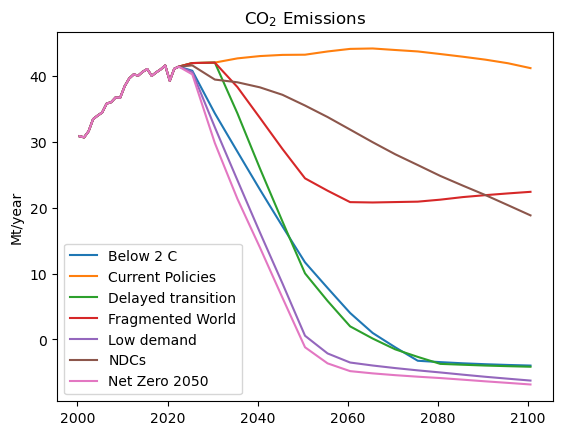

In [82]:
for scen in f_GCAM.scenarios:
     plt.plot(f_GCAM.timepoints[250:], f_GCAM.emissions.loc[dict(scenario=scen, specie='CO2')].values[250:], label=scen)
        
plt.title('CO$_2$ Emissions')
plt.ylabel('Mt/year')
plt.legend()
plt.show()

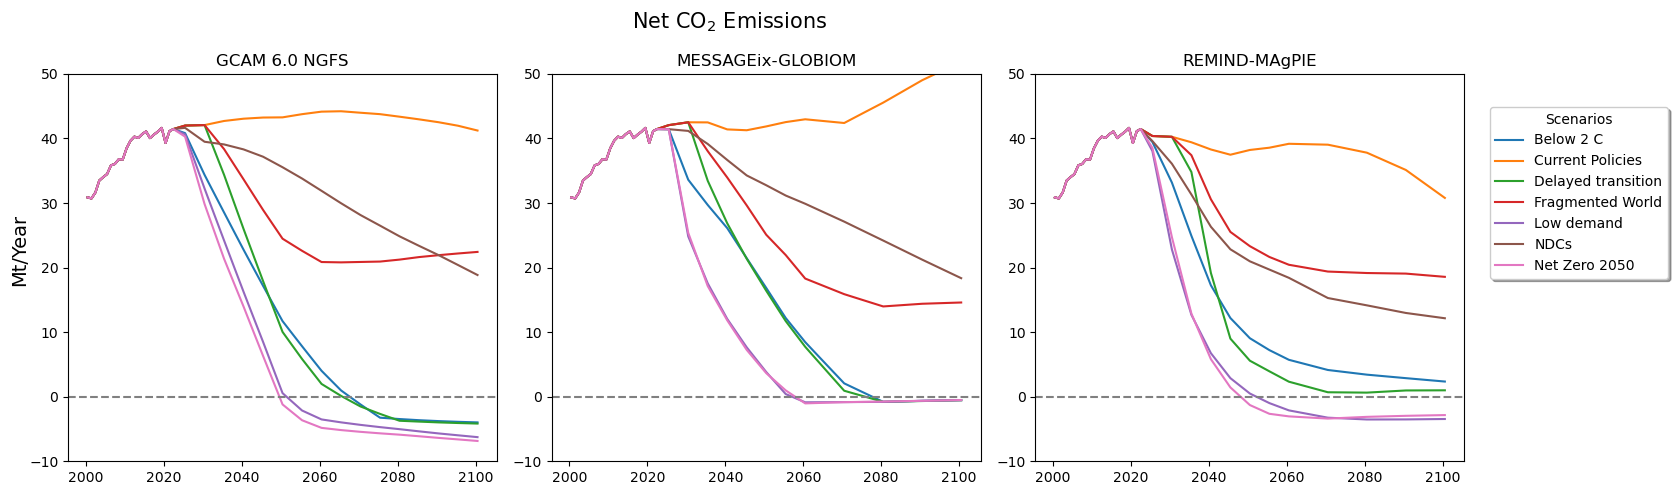

In [90]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, f in enumerate(iam_names):
    labels = []
    ax = axs[i]
    
    for scen in f.scenarios:
        line, = ax.plot(f.timepoints[250:], 
                        f.emissions.loc[dict(scenario=scen, specie='CO2')].values[250:],
                        label=scen)
        labels.append(line,)
    ax.set_title(iam_names[f])
    ax.set_ylim(-10,50)
    ax.axhline(0, color='grey', linestyle='--')

fig.legend(labels, [line.get_label() for line in labels], bbox_to_anchor=(1.13, .8), shadow=True, title='Scenarios')
fig.suptitle('Net CO$_2$ Emissions', fontsize=15)
# fig.supxlabel('Year', fontsize=14)
fig.supylabel('Mt/Year', fontsize=14)
fig.tight_layout()
fig.show()